<a href="https://colab.research.google.com/github/beaufort07/Masterthesis/blob/main/WoodAnomaliesAutoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import os
import cv2
import random

In [2]:
!mkdir test
!mkdir test/unknown

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [5]:
paths=[]
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Masterarbeit/mvtec/wood/test/'):
    for filename in filenames:
        paths+=[(os.path.join(dirname, filename))]
#tpaths=random.sample(paths,30)
tpaths=paths

In [6]:
labels=[] # labels = true label
for path in tpaths:
    label=path.split('/')[-2]
    labels+=[label]
    file=label+'_'+path.split('/')[-1]
    to_path='test/unknown/'+file
    !cp {path} {to_path}

result=pd.DataFrame(columns=['path','label'])
result['path']=tpaths
result['label']=labels
display(result)

,path,label
0,/content/drive/MyDrive/Masterarbeit/mvtec/wood...,combined
1,/content/drive/MyDrive/Masterarbeit/mvtec/wood...,combined
2,/content/drive/MyDrive/Masterarbeit/mvtec/wood...,combined
3,/content/drive/MyDrive/Masterarbeit/mvtec/wood...,combined
4,/content/drive/MyDrive/Masterarbeit/mvtec/wood...,combined
...,...,...
74,/content/drive/MyDrive/Masterarbeit/mvtec/wood...,good
75,/content/drive/MyDrive/Masterarbeit/mvtec/wood...,good
76,/content/drive/MyDrive/Masterarbeit/mvtec/wood...,good
77,/content/drive/MyDrive/Masterarbeit/mvtec/wood...,good


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224,224)), # Unify images to (224,224) size
    transforms.ToTensor()
])

train_dir='/content/drive/MyDrive/Masterarbeit/mvtec/wood/train'
valid_dir='/content/drive/MyDrive/Masterarbeit/mvtec/wood/test/'

subset_size=20
train_dataset = ImageFolder(root=train_dir, transform=transform)
subset_indices = torch.randperm(len(train_dataset))[:subset_size]
subset_mvt = Subset(train_dataset, subset_indices)

# Create the subset DataLoader
batch_size = 32
train_loader = DataLoader(subset_mvt, batch_size=batch_size, shuffle=True)

#train_loader = DataLoader(random_sample, batch_size=8, shuffle=True)

valid_dataset = ImageFolder(root=valid_dir, transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)
class_names = valid_dataset.classes

print(class_names)
print(len(subset_mvt))

test_dir='test'

test_dataset= ImageFolder(root=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

['color', 'combined', 'good', 'hole', 'liquid', 'scratch']
20


In [8]:
print(train_dataset)

Dataset ImageFolder
    Number of datapoints: 194
    Root location: /content/drive/MyDrive/Masterarbeit/mvtec/wood/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [9]:
print(random_sample)

NameError: name 'random_sample' is not defined

In [ ]:
paths=[]
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Masterarbeit/mvtec/wood/test/good'):
    for filename in filenames:
        paths+=[(os.path.join(dirname, filename))]
paths=random.sample(paths,8)

fig, axs = plt.subplots(2,4,figsize=(12,5))
for i in range(8):
    r=i//4
    c=i%4
    path=paths[i]
    file=path.split('/')[-1]
    img = plt.imread(path)
    label=path.split('/')[-2]
    ax=axs[r][c].axis("off")
    ax=axs[r][c].set_title(label)
    ax=axs[r][c].imshow(img)

plt.show()

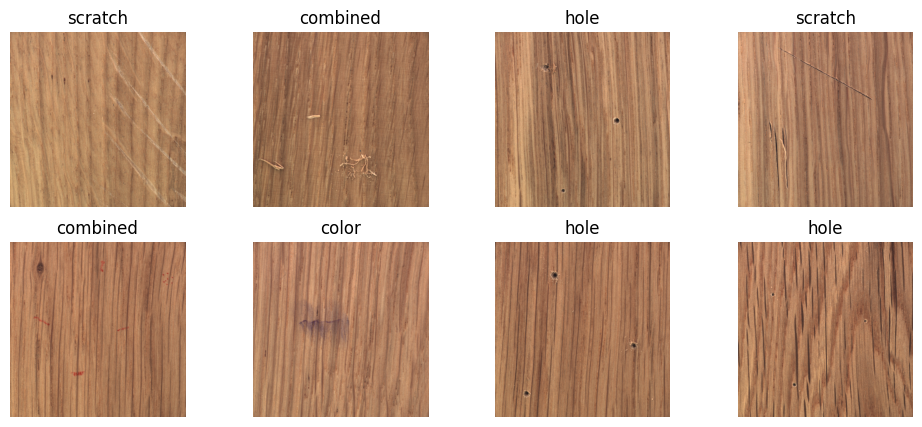

In [30]:
paths2=[]
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Masterarbeit/mvtec/wood/test'):
    for filename in filenames:
        if dirname.split('/')[-1]!='good':
            paths2+=[(os.path.join(dirname, filename))]
paths2=random.sample(paths2,8)

fig, axs = plt.subplots(2,4,figsize=(12,5))
for i in range(8):
    r=i//4
    c=i%4
    path=paths2[i]
    file=path.split('/')[-1]
    img = plt.imread(path)
    label=path.split('/')[-2]
    ax=axs[r][c].axis("off")
    ax=axs[r][c].set_title(label)
    ax=axs[r][c].imshow(img)

plt.show()

In [11]:
# Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [12]:
# Instantiate Autoencoder and send to GPU
autoencoder = Autoencoder().to(device)

# Definition of loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

In [13]:
# training
for epoch in range(100):
    running_loss = 0.0
    for data in train_loader:
        img, _ = data
        img = Variable(img).to(device)
        optimizer.zero_grad()
        outputs = autoencoder(img)
        loss = criterion(outputs, img)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print('Epoch [%d], Loss: %.4f' % (epoch+1, running_loss/len(train_loader)))

Epoch [1], Loss: 0.2634
Epoch [2], Loss: 0.2628
Epoch [3], Loss: 0.2620
Epoch [4], Loss: 0.2612
Epoch [5], Loss: 0.2603
Epoch [6], Loss: 0.2594
Epoch [7], Loss: 0.2585
Epoch [8], Loss: 0.2577
Epoch [9], Loss: 0.2568
Epoch [10], Loss: 0.2559
Epoch [11], Loss: 0.2550
Epoch [12], Loss: 0.2541
Epoch [13], Loss: 0.2532
Epoch [14], Loss: 0.2523
Epoch [15], Loss: 0.2514
Epoch [16], Loss: 0.2504
Epoch [17], Loss: 0.2495
Epoch [18], Loss: 0.2485
Epoch [19], Loss: 0.2475
Epoch [20], Loss: 0.2464
Epoch [21], Loss: 0.2454
Epoch [22], Loss: 0.2443
Epoch [23], Loss: 0.2432
Epoch [24], Loss: 0.2420
Epoch [25], Loss: 0.2408
Epoch [26], Loss: 0.2394
Epoch [27], Loss: 0.2379
Epoch [28], Loss: 0.2362
Epoch [29], Loss: 0.2342
Epoch [30], Loss: 0.2319
Epoch [31], Loss: 0.2291
Epoch [32], Loss: 0.2258
Epoch [33], Loss: 0.2215
Epoch [34], Loss: 0.2162
Epoch [35], Loss: 0.2101
Epoch [36], Loss: 0.2031
Epoch [37], Loss: 0.1953
Epoch [38], Loss: 0.1866
Epoch [39], Loss: 0.1774
Epoch [40], Loss: 0.1683
Epoch [41

In [14]:
# test

autoencoder.eval()
Yi_pred=[]
for batch in test_loader:
    img, label = batch
    img = Variable(img).to(device)
    outputs = autoencoder(img)
    #loss = criterion(outputs, img)
    #lossi = loss.item()
    yi_pred=[]
    for i in range(len(img)):
        lossi=criterion(outputs[i], img[i])
        yi_pred+=[lossi.item()]

    Yi_pred+=yi_pred

result['y_pred']=Yi_pred
display(result)

,path,label,y_pred
0,/content/drive/MyDrive/Masterarbeit/mvtec/wood...,combined,0.046149
1,/content/drive/MyDrive/Masterarbeit/mvtec/wood...,combined,0.049502
2,/content/drive/MyDrive/Masterarbeit/mvtec/wood...,combined,0.045395
3,/content/drive/MyDrive/Masterarbeit/mvtec/wood...,combined,0.031624
4,/content/drive/MyDrive/Masterarbeit/mvtec/wood...,combined,0.046126
...,...,...,...
74,/content/drive/MyDrive/Masterarbeit/mvtec/wood...,good,0.047604
75,/content/drive/MyDrive/Masterarbeit/mvtec/wood...,good,0.037883
76,/content/drive/MyDrive/Masterarbeit/mvtec/wood...,good,0.037085
77,/content/drive/MyDrive/Masterarbeit/mvtec/wood...,good,0.043102


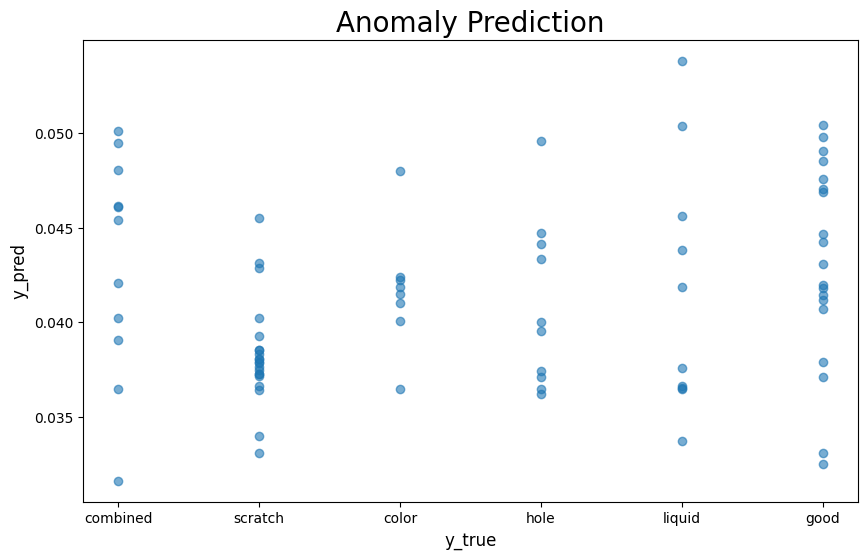

In [15]:
fig,ax = plt.subplots(figsize=(10,6))
ax.set_title('Anomaly Prediction',fontsize=20)
ax.set_xlabel('y_true',fontsize=12)
ax.set_ylabel('y_pred',fontsize=12)
ax.scatter(result['label'],result['y_pred'],alpha=0.6)
plt.show()

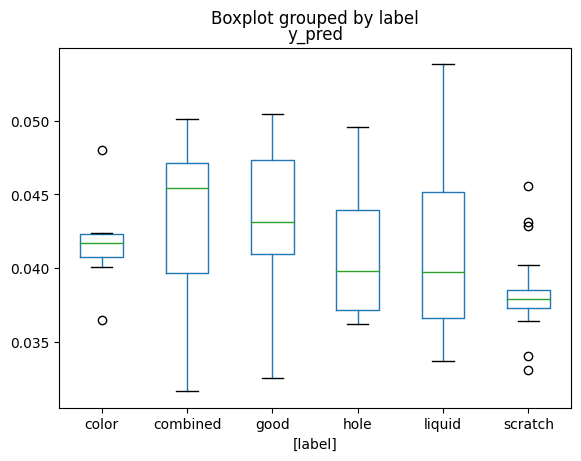

In [16]:
result.boxplot(by='label',grid=False)
plt.show()

In [17]:
print(result)

                                                 path     label    y_pred
0   /content/drive/MyDrive/Masterarbeit/mvtec/wood...  combined  0.046149
1   /content/drive/MyDrive/Masterarbeit/mvtec/wood...  combined  0.049502
2   /content/drive/MyDrive/Masterarbeit/mvtec/wood...  combined  0.045395
3   /content/drive/MyDrive/Masterarbeit/mvtec/wood...  combined  0.031624
4   /content/drive/MyDrive/Masterarbeit/mvtec/wood...  combined  0.046126
..                                                ...       ...       ...
74  /content/drive/MyDrive/Masterarbeit/mvtec/wood...      good  0.047604
75  /content/drive/MyDrive/Masterarbeit/mvtec/wood...      good  0.037883
76  /content/drive/MyDrive/Masterarbeit/mvtec/wood...      good  0.037085
77  /content/drive/MyDrive/Masterarbeit/mvtec/wood...      good  0.043102
78  /content/drive/MyDrive/Masterarbeit/mvtec/wood...      good  0.049790

[79 rows x 3 columns]


In [18]:
result['class']=np.where(result['label']=='good','good','outlier')
print(result)

                                                 path     label    y_pred  \
0   /content/drive/MyDrive/Masterarbeit/mvtec/wood...  combined  0.046149   
1   /content/drive/MyDrive/Masterarbeit/mvtec/wood...  combined  0.049502   
2   /content/drive/MyDrive/Masterarbeit/mvtec/wood...  combined  0.045395   
3   /content/drive/MyDrive/Masterarbeit/mvtec/wood...  combined  0.031624   
4   /content/drive/MyDrive/Masterarbeit/mvtec/wood...  combined  0.046126   
..                                                ...       ...       ...   
74  /content/drive/MyDrive/Masterarbeit/mvtec/wood...      good  0.047604   
75  /content/drive/MyDrive/Masterarbeit/mvtec/wood...      good  0.037883   
76  /content/drive/MyDrive/Masterarbeit/mvtec/wood...      good  0.037085   
77  /content/drive/MyDrive/Masterarbeit/mvtec/wood...      good  0.043102   
78  /content/drive/MyDrive/Masterarbeit/mvtec/wood...      good  0.049790   

      class  
0   outlier  
1   outlier  
2   outlier  
3   outlier  
4   o

In [19]:
result['pred_class']=np.where(result['y_pred']<0.042,'outlier','good') # predicted class
print(sum(result['pred_class']=='outlier'))
print(sum(result['pred_class']=='good'))
print(result)

48
31
                                                 path     label    y_pred  \
0   /content/drive/MyDrive/Masterarbeit/mvtec/wood...  combined  0.046149   
1   /content/drive/MyDrive/Masterarbeit/mvtec/wood...  combined  0.049502   
2   /content/drive/MyDrive/Masterarbeit/mvtec/wood...  combined  0.045395   
3   /content/drive/MyDrive/Masterarbeit/mvtec/wood...  combined  0.031624   
4   /content/drive/MyDrive/Masterarbeit/mvtec/wood...  combined  0.046126   
..                                                ...       ...       ...   
74  /content/drive/MyDrive/Masterarbeit/mvtec/wood...      good  0.047604   
75  /content/drive/MyDrive/Masterarbeit/mvtec/wood...      good  0.037883   
76  /content/drive/MyDrive/Masterarbeit/mvtec/wood...      good  0.037085   
77  /content/drive/MyDrive/Masterarbeit/mvtec/wood...      good  0.043102   
78  /content/drive/MyDrive/Masterarbeit/mvtec/wood...      good  0.049790   

      class pred_class  
0   outlier       good  
1   outlier       g

In [20]:
result['TP']=np.where(np.logical_and(result['class']=='outlier',result['pred_class']=='outlier'),True,False)
result['TN']=np.where(np.logical_and(result['class']=='good',result['pred_class']=='good'),True,False)
result['FP']=np.where(np.logical_and(result['class']=='good',result['pred_class']=='outlier'),True,False)
result['FN']=np.where(np.logical_and(result['class']=='outlier',result['pred_class']=='good'),True,False)

In [21]:
print(result)

                                                 path     label    y_pred  \
0   /content/drive/MyDrive/Masterarbeit/mvtec/wood...  combined  0.046149   
1   /content/drive/MyDrive/Masterarbeit/mvtec/wood...  combined  0.049502   
2   /content/drive/MyDrive/Masterarbeit/mvtec/wood...  combined  0.045395   
3   /content/drive/MyDrive/Masterarbeit/mvtec/wood...  combined  0.031624   
4   /content/drive/MyDrive/Masterarbeit/mvtec/wood...  combined  0.046126   
..                                                ...       ...       ...   
74  /content/drive/MyDrive/Masterarbeit/mvtec/wood...      good  0.047604   
75  /content/drive/MyDrive/Masterarbeit/mvtec/wood...      good  0.037883   
76  /content/drive/MyDrive/Masterarbeit/mvtec/wood...      good  0.037085   
77  /content/drive/MyDrive/Masterarbeit/mvtec/wood...      good  0.043102   
78  /content/drive/MyDrive/Masterarbeit/mvtec/wood...      good  0.049790   

      class pred_class     TP     TN     FP     FN  
0   outlier       good

In [22]:
TP=sum(result['TP']==True)
TN=sum(result['TN']==True)
FP=sum(result['FP']==True)
FN=sum(result['FN']==True)
P=TP+FN
N=FP+TN
PP=TP+FP
PN=FN+TN
print('TP: ',TP)
print('TN: ',TN)
print('FP: ',FP)
print('FN: ',FN)

TP:  39
TN:  10
FP:  9
FN:  21


In [23]:
Recall=TP/P
Precision=TP/PP
Accuracy=(TP+TN)/(P+N)
print('Recall: ',Recall)
print('Precision: ',Precision)
print('Accuracy: ',Accuracy)


Recall:  0.65
Precision:  0.8125
Accuracy:  0.620253164556962
